In [1]:
# Importing the libraries we're going to use.
import matplotlib.pyplot as plt
import pandas as pd

from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, TimestampType, DoubleType
from pyspark.sql.functions import coalesce, col, lag, lit, round, sum, avg, radians, acos, sin, cos
from pyspark.sql.window import Window

import findspark
import gpxpy

# This library helps to the Python session within the current Jupyter Kernel to find Spark in the container. 
findspark.init()

In [2]:
# Innitialize the Spark Session and get the SparkContext from it.
spark = SparkSession\
    .builder\
    .enableHiveSupport()\
    .getOrCreate()

sc = spark.sparkContext

display(spark, sc)

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/06/08 00:30:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/06/08 00:30:57 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
22/06/08 00:30:57 WARN Utils: The configured local directories are not expected to be URIs; however, got suspicious values [file:/tmp/spark]. Please check your configured local directories.
22/06/08 00:30:58 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


<SparkContext master=local appName=GPSTrackingSystem>

In [5]:
# Defines the struct for the DataFrame
columns = StructType([
    StructField('time', TimestampType(), True),
    StructField('latitude', DoubleType(), True),
    StructField('longitude', DoubleType(), True)
])

# Opens and parse the GPS track stored within the *.gpx file.
# After parsing the file, the geo point are then loaded into a Spark DataFrame.
with open('/opt/etl/data/vehicles/motorcycle/AAA_11B/recovery.05-Mar-2022.1025.gpx') as fr:
    gpx_parser = gpxpy.parse(fr)
    raw_geo_df = spark.createDataFrame(map(
        lambda p: (
            p.time,
            p.latitude,
            p.longitude
        ),
        gpx_parser.tracks[0].segments[0].points
    ), columns).orderBy(col('time'), asceding=True)

raw_geo_df.show(10)

+-------------------+-----------------+------------------+
|               time|         latitude|         longitude|
+-------------------+-----------------+------------------+
|2022-03-04 00:04:34|6.180892554117535|-75.57729642845278|
|2022-03-04 00:04:35|6.180912000132893|-75.57729458443409|
|2022-03-04 00:04:43|6.180921471683477|-75.57731159969752|
|2022-03-04 00:04:46|6.180897499440406|-75.57727027691489|
|2022-03-04 00:04:48|6.180873904382978|-75.57727589279001|
|2022-03-04 00:04:49|6.180848758673464|-75.57726575068718|
|2022-03-04 00:04:50|6.180861708713864|-75.57727740153258|
|2022-03-04 00:04:51|6.180877131415699|-75.57728913619702|
|2022-03-04 00:05:21|6.180952820001338|-75.57734990499502|
|2022-03-04 00:05:23|6.181004368705843|-75.57722702629452|
+-------------------+-----------------+------------------+
only showing top 10 rows



In [6]:
# Defines the haversine formula within a Spark UDF for retrieving the accurate distances between points.
# Refer to https://en.wikipedia.org/wiki/Haversine_formula for deeper knowledge of this formula.
def haversine(lat1, lon1, lat2, lon2):
    """
    Allows to calculate distance between two points using
    Haversine, reference https://en.wikipedia.org/wiki/Haversine_formula
    """
    # Convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    distance = acos(sin(lat1) * sin(lat2) + cos(lat1) * cos(lat2) * cos(lat1 - lat2))
    # Radius of earth in kilometers is 6371.01

    return distance * 6371.01

# Created a Windows with 1 lag to apply it into the latitude, longitude and times.
w = Window().partitionBy().orderBy(col('time'))

# Applies the window into the DataFrame containing the Geo points.
# This will shift by 1 position all the rows within the DataFrame.
windowed_df = raw_geo_df.select(
    '*',
    lag(col('time')).over(w).alias('old_time'),
    lag(col('latitude')).over(w).alias('old_latitude'),
    lag(col('longitude')).over(w).alias('old_longitude')
)

# Adds the columns:
# distance_km: float - distance between point P(n) and P(n-1)
# time_elapsed_hours: long - time elapsed between meassurements T(n) and T(n-1)
# speed_kmh: float - speed at a given time in km/h
consolidated_df = windowed_df\
    .withColumn('distance_km', coalesce(haversine(col('old_latitude'), col('old_longitude'), col('latitude'), col('longitude')), lit(0)))\
    .withColumn('time_elapsed_hours', coalesce(col('time').cast('long') - col('old_time').cast('long'), lit(0)) / 3600)\
    .withColumn('speed_kmh', round(coalesce(col('distance_km') / col('time_elapsed_hours'), lit(0)), 2)).na.drop()

consolidated_df.show(10)

22/06/08 00:36:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/08 00:36:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/08 00:36:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+-------------------+-----------------+------------------+-------------------+-----------------+------------------+--------------------+--------------------+---------+
|               time|         latitude|         longitude|           old_time|     old_latitude|     old_longitude|         distance_km|  time_elapsed_hours|speed_kmh|
+-------------------+-----------------+------------------+-------------------+-----------------+------------------+--------------------+--------------------+---------+
|2022-03-04 00:04:35|6.180912000132893|-75.57729458443409|2022-03-04 00:04:34|6.180892554117535|-75.57729642845278|0.003049778146654386|2.777777777777778E-4|    10.98|
|2022-03-04 00:04:43|6.180921471683477|-75.57731159969752|2022-03-04 00:04:35|6.180912000132893|-75.57729458443409|0.001489004303834...|0.002222222222222...|     0.67|
|2022-03-04 00:04:46|6.180897499440406|-75.57727027691489|2022-03-04 00:04:43|6.180921471683477|-75.57731159969752|0.003759251906639...|8.333333333333334E-4|   

22/06/08 00:36:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.



In [7]:
# Creates a Pandas DataFrame after deleting any NA found in the DataFrame
pandas_df = consolidated_df.na.drop().toPandas().set_index('time')

# Gets a summary of:
# total_time_ride_hours: float - total time taken within the ride from start to end in hours.
# total_distance_km: float - total distance rode from start to end.
# avg_speed_ride_kmh: float - Average speed during the entire ride.
# avg_measurement_interval_seconds: float - Average time between intervals in seconds.
summary_df = consolidated_df.na.drop().select(
    sum('time_elapsed_hours').alias('total_time_ride_hours'),
    sum('distance_km').alias('total_distance_ride_km'),
    avg('speed_kmh').alias('avg_speed_ride_kmh'),
    (avg('time_elapsed_hours') * 3600).alias('avg_measurement_interval_seconds')
)

# Converts the summary DataFrame into a Python dictionary.
summary = summary_df.rdd.map(lambda row: row.asDict()).collect()[0]

display(summary)

22/06/08 00:36:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/08 00:36:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/08 00:36:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/08 00:36:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/08 00:37:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/08 00:37:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/08 0

{'total_time_ride_hours': 39.35250000000208,
 'total_distance_ride_km': 136.79343619124174,
 'avg_speed_ride_kmh': 23.21257221236079,
 'avg_measurement_interval_seconds': 7.620300145231966}

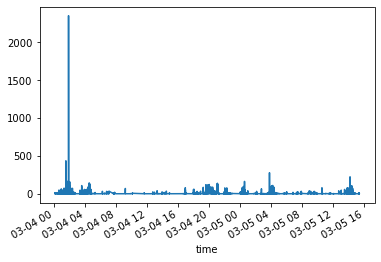

In [8]:
# Plots the speed during the entire ride.
# There are several peaks that look abnormal in the diagram.
# This could mean an error of the GPS tracking app while was recording the Geolocations.
# This can be solved by normalizing the Time Series, cleaning the raw data, replacing the points by the average of P(n-1) and P(n+1),
# removing those point or setting a range to ignore those gaps.

pandas_df['speed_kmh'].plot()

In [9]:
# For this example let's set a range between 0 and 120 km/h to ignore those gaps.

pandas_df[pandas_df['speed_kmh'] > 120]

,latitude,longitude,old_time,old_latitude,old_longitude,distance_km,time_elapsed_hours,speed_kmh
time,,,,,,,,
2022-03-04 01:29:39,6.134296,-75.619850,2022-03-04 01:29:38,6.133525,-75.619258,0.120884,0.000278,435.18
2022-03-04 01:33:15,6.133692,-75.619152,2022-03-04 01:33:14,6.133378,-75.619179,0.049192,0.000278,177.09
2022-03-04 01:45:01,6.133706,-75.619164,2022-03-04 01:45:00,6.133419,-75.619219,0.045103,0.000278,162.37
2022-03-04 01:46:01,6.133665,-75.619203,2022-03-04 01:46:00,6.133427,-75.619231,0.037294,0.000278,134.26
2022-03-04 01:50:17,6.136952,-75.620365,2022-03-04 01:50:16,6.136096,-75.620175,0.134159,0.000278,482.97
...,...,...,...,...,...,...,...,...
2022-03-04 21:07:57,6.230341,-75.575192,2022-03-04 21:07:56,6.230118,-75.575203,0.034885,0.000278,125.59
2022-03-05 00:35:26,6.240605,-75.586868,2022-03-05 00:35:25,6.240894,-75.586622,0.045300,0.000278,163.08
2022-03-05 00:35:39,6.241035,-75.586590,2022-03-05 00:35:38,6.240789,-75.586643,0.038630,0.000278,139.07


In [10]:
summary_df = consolidated_df.na.drop().filter(col('speed_kmh') <= 120).select(
    sum('time_elapsed_hours').alias('total_time_ride_hours'),
    sum('distance_km').alias('total_distance_ride_km'),
    avg('speed_kmh').alias('avg_speed_ride_kmh'),
    (avg('time_elapsed_hours') * 3600).alias('avg_measurement_interval_seconds')
)

summary = summary_df.rdd.map(lambda row: row.asDict()).collect()[0]

summary

22/06/08 00:37:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/08 00:37:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/08 00:37:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


{'total_time_ride_hours': 39.278888888890926,
 'total_distance_ride_km': 126.66294716623023,
 'avg_speed_ride_kmh': 21.59696776305019,
 'avg_measurement_interval_seconds': 7.713085692467535}

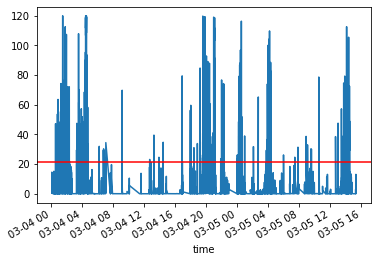

In [12]:
pandas_df[pandas_df['speed_kmh'] <= 120]['speed_kmh'].plot()
plt.axhline(y=summary['avg_speed_ride_kmh'], color='red')